In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json 
import math 

# Data and Main Variables

In [2]:
models = [
    "jinaai/jina-embeddings-v3",
    "Snowflake/snowflake-arctic-embed-l-v2.0", 
    "BAAI/bge-m3", 
    'sentence-transformers/all-MiniLM-L6-v2', 
    'sentence-transformers/all-mpnet-base-v2', 
    'Qwen/Qwen3-Embedding-0.6B', 
    'google/embeddinggemma-300m',
]

In [3]:
df = pd.read_parquet("data/embeddings/unclean_data/speech_embeddings.parquet")
vocab_df = pd.read_parquet("data/embeddings/unclean_data/vocab_embeddings (1).parquet")

color_maps = {
    "party": json.load(open("color_maps/color_map_eu_party.json")), 
    "block": json.load(open("color_maps/color_map_party_blocks.json"))
}

In [4]:
from scripts.preprocessing import remove_non_party_speeches, rename_party_duplicates, add_party_orientation_year_agenda 

def process_df(df): 
    for step in [remove_non_party_speeches, add_party_orientation_year_agenda, rename_party_duplicates, ]: 
        df = step(df) 

    return df

In [5]:
df.rename(columns={"eu_party": "party"}, inplace=True)
df = process_df(df)

Removing speakers without party: 0 (0.00)


In [6]:
df = df[(df['text'].str.len() < 1_300) & (df['text'].str.len() > 700)]
df = df[df["year"] > 2010]

In [7]:
def medioid(embedding): 
    embedding = np.stack(embedding)
    rsm = embedding @ embedding.T 
    most_representative_index = np.argmax(np.sum(rsm, axis=1))
    return embedding[most_representative_index, :]

def mean(embedding): 
    return np.stack(embedding).mean(axis=0)

In [8]:
EMBEDDING_COLUMN = models[5]
AGGREGATION_VARIABLE = "block"
AGGREGATION_METHOD = mean
color_map = color_maps[AGGREGATION_VARIABLE]

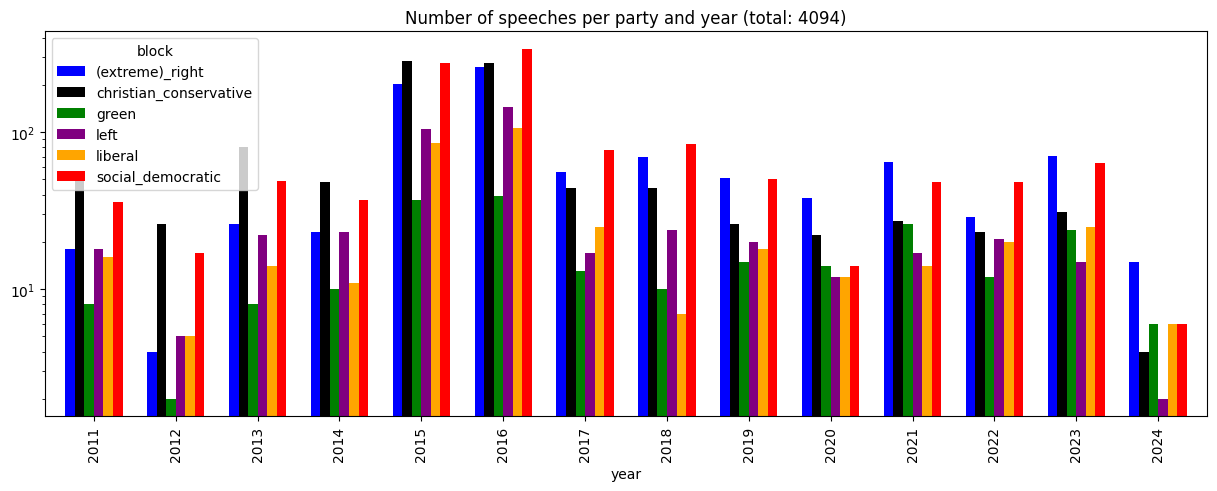

In [9]:
ax = df.groupby(["year", AGGREGATION_VARIABLE]).size().unstack().plot(kind="bar", stacked=False, figsize=(15, 5), width=0.7, color=color_map)
ax.set_title(f"Number of speeches per party and year (total: {len(df)})")
ax.set_yscale("log")

# Helper Functions

In [10]:
def get_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str, embedding_agg_method=mean):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    aggregated_embeddings = yearly_data.groupby(by=[aggregate_on, 'year'])[embedding_column].agg(embedding_agg_method)
    return aggregated_embeddings.reset_index()

# Patterns over time

## PCA based shifts

In [11]:
from sklearn.decomposition import PCA


aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_COLUMN, AGGREGATION_VARIABLE, AGGREGATION_METHOD)
pca = PCA(n_components=2)
reduced = pca.fit_transform(np.stack(aggregated[EMBEDDING_COLUMN]))
print("PCA explained variance:", pca.explained_variance_.sum())

PCA explained variance: 0.013024705


In [12]:
import re
vocab = list(df['text'].str.split().explode().apply(lambda word: {"cleared": re.sub(r'\W+', '', word).lower(),
                                                                      "original": word}))

In [13]:
cleaned_to_original = {pair['cleared']: pair['original'] for pair in vocab}

In [14]:
def closest_words_for_pc(k, eigen_vectors, vocab, probe_embs, top_n=20):
    pc_vec = eigen_vectors[k]
    pc_vec = pc_vec / np.linalg.norm(pc_vec)
    sims = probe_embs @ pc_vec   

    sorted_indices = np.argsort(sims)
    pos_idx = sorted_indices[-top_n:]
    mid_position = len(sorted_indices)//2
    mid_idx = sorted_indices[mid_position-math.floor(top_n/2) : mid_position+math.ceil(top_n/2)]
    neg_idx = sorted_indices[:top_n]


    def map_indices_to_examples(index_list): 
        if isinstance(vocab, pd.DataFrame) or isinstance(vocab, pd.Series): 
            return [(vocab.iloc[i], sims[i]) for i in index_list]
        else:
            return [(vocab[i], sims[i]) for i in index_list]

    return map_indices_to_examples(neg_idx), map_indices_to_examples(mid_idx), map_indices_to_examples(pos_idx)
    # return ([(vocab[i], sims[i]) for i in neg_idx], [(vocab[i], sims[i]) for i in reversed(pos_idx)])

## Combined

In [15]:
pca_axis_labels = [dict(), dict()]
for axis in [0, 1]: 
    pca_axis_neg, pca_axis_neutr, pca_axis_pos = closest_words_for_pc(axis, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=3)
    pca_axis_labels[axis]["neg"] = pca_axis_neg
    pca_axis_labels[axis]["neutr"] = pca_axis_neutr
    pca_axis_labels[axis]["pos"] = pca_axis_pos

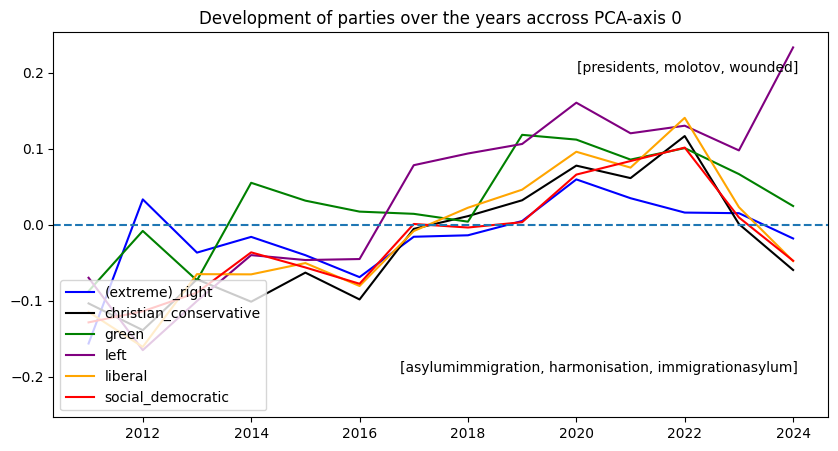

In [21]:
def plot_pca_axis_development(pca_axis):
    # pca_axis_labels = closest_words_for_pc(pca_axis, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=3)

    f = plt.figure(figsize=(10, 5))
    plt.title(f"Development of parties over the years accross PCA-axis {pca_axis}")

    for party in aggregated[AGGREGATION_VARIABLE].unique():
        party_mask = aggregated[AGGREGATION_VARIABLE] == party
        years = aggregated[party_mask]['year']
        party_embeddings = reduced[party_mask]
        plt.plot(years, party_embeddings[:, pca_axis], color=color_map[party], label=party)

        # plt.ylim()

    max_y_lim = max(abs(plt.ylim()[0]), abs(plt.ylim()[1]))

    plt.ylim((-max_y_lim, max_y_lim))  
    plt.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], pca_axis_labels[pca_axis]['neg']))
    # ax_label_neutr = ', '.join(map(lambda x: x[0], pca_axis_labels[pca_axis]['neutr']))
    ax_label_pos = ', '.join(map(lambda x: x[0], pca_axis_labels[pca_axis]['pos']))

    # label for negative axis: 
    plt.figtext(0.87, 0.2, f"[{ax_label_neg}]", horizontalalignment="right")
    # label for positive axis: 
    # plt.figtext(0.87, 0.5, f"[{ax_label_neutr}]", horizontalalignment="right")
    # label for positive axis: 
    plt.figtext(0.87, 0.8, f"[{ax_label_pos}]", horizontalalignment="right")
    plt.legend(loc="lower left")
plot_pca_axis_development(0)


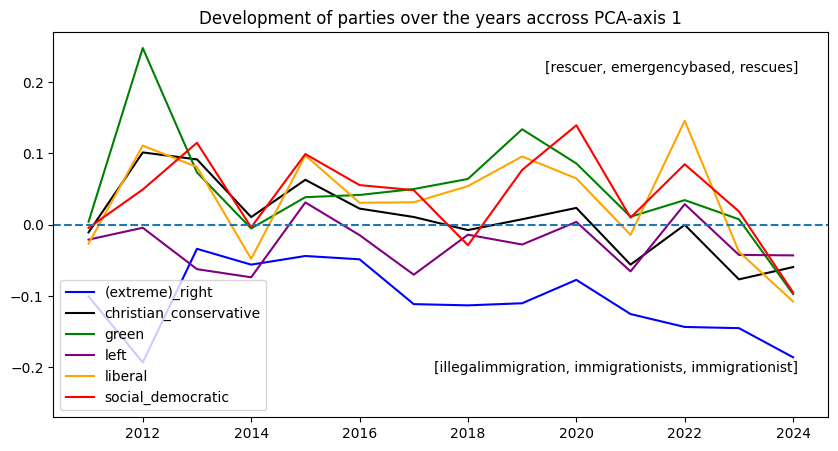

In [23]:
plot_pca_axis_development(1)

## Examples
### First: most extreme in full dataframe

In [24]:
def print_extreme_examlpes(axis, df_group):
    examples = closest_words_for_pc(axis, pca.components_, df_group, np.stack(df_group[EMBEDDING_COLUMN]), top_n=1)

    print(f"Axis {axis} ({list(map(lambda s: s[0], pca_axis_labels[axis]['neg']))} <=> {list(map(lambda s: s[0], pca_axis_labels[axis]['pos']))})")

    for i, polarity in enumerate(["-", "n", "+"]): 
        example = examples[i][0][0]
        similarity = examples[i][0][1]

        print(f"{polarity} score {similarity}: {example['speaker']} ({example['block']}) {example['date']} \n\t'{example['text']}'")

In [25]:
print_extreme_examlpes(0, df)
print("\n")
print_extreme_examlpes(1, df)

Axis 0 (['asylumimmigration', 'harmonisation', 'immigrationasylum'] <=> ['presidents', 'molotov', 'wounded'])
- score -0.37995606660842896: birgit collin-langen (christian_conservative) 2016-04-12 
	'I voted for the report because I support the call for uniform EU regulations so that we can better cope with the growing influx of migrants and asylum seekers in the future. We need to revise the Dublin system and make improvements where there are difficulties today: it is important to introduce uniform standards so that asylum applications are examined and processed according to the same criteria everywhere, it is important to provide safe and legal routes for nationals of third countries, who want to enter the EU without them risking their lives and having to resort to smugglers. This is not about quick solutions, but rather a sustainable approach that gives us a long-term, practical solution!'
n score -0.08323941379785538: monika hohlmeier (christian_conservative) 2012-04-19 
	'(DE) Mad

### Now: per party per year

In [26]:
def print_extreme_examlpes_per_block_and_year(group, year, axis): 
    df_group = df[df["block"] == group]
    df_group_year = df_group[df_group["year"] == year]
    
    print("n", len(df_group_year))
    print_extreme_examlpes(axis, df_group_year)

    # per year, get most extreme (pos and negative), and most representative (medioid) 
print_extreme_examlpes_per_block_and_year("left", 2012, axis=1)

n 5
Axis 1 (['illegalimmigration', 'immigrationists', 'immigrationist'] <=> ['rescuer', 'emergencybased', 'rescues'])
- score -0.020182041451334953: jiří maštálka (left) 2012-03-15 
	'Madam President, I too am deeply outraged by the tragic fate of the migrants from Sub-Saharan Africa. I support the proposal for the European Parliament to join those demanding that the Egyptian authorities review their policy towards migrants and people traffickers. However, I do not want it to be said again that we notice the problems of others while ignoring our own. I would like to emphasise above all that not every refugee is a political refugee. Many are fleeing for religious reasons and most are social migrants. Do we know how many of these migrants perished last year on the borders of Europe - or the Schengen borders, if you prefer? Piecemeal measures cannot prevent people being treated like commodities. In today’s world, rich nations, states and regions have a specific responsibility - a responsi